In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import xgboost as xgb

# Lire le fichier .dat
df = pd.read_csv("dataset.dat", parse_dates=["TIMESTAMP"], na_values=["NAN"])

# Chargement du dataset
df.columns = df.columns.str.lower()
df.rename(columns={"timestamp": "ts"}, inplace=True)
df["ts"] = pd.to_datetime(df["ts"])
df.sort_values("ts", inplace=True)
df.reset_index(drop=True, inplace=True)

# Analyse Exploratoire

In [46]:
df.isna().sum() 

ts                 0
deplacement       87
ensoleillement     0
temperature        0
dtype: int64

In [47]:
# interpollation linéaire sur les NaN de déplacement
df["deplacement"] = df["deplacement"].interpolate(limit_direction="both")

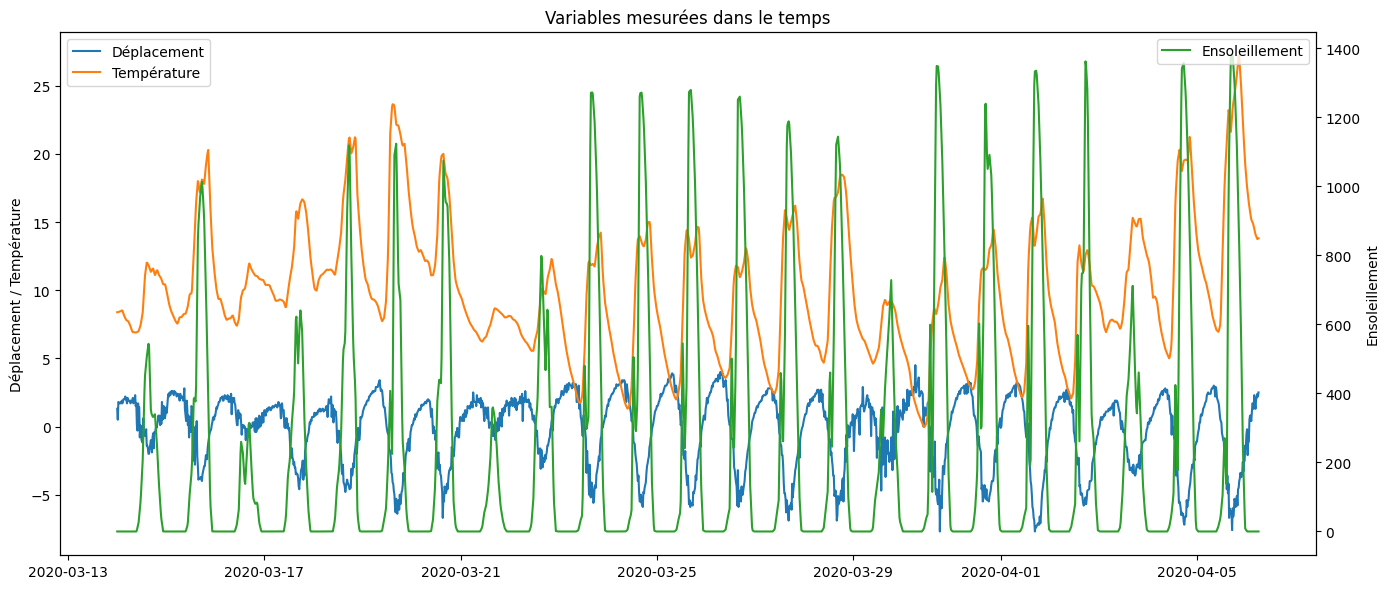

In [48]:
## Visualisation des données
fig, ax1 = plt.subplots(figsize=(14, 6))

# Premier axe : déplacement + température
ax1.plot(df["ts"], df["deplacement"], label="Déplacement", color="tab:blue")
ax1.plot(df["ts"], df["temperature"], label="Température", color="tab:orange")
ax1.set_ylabel("Déplacement / Température")
ax1.legend(loc="upper left")

# Deuxième axe : ensoleillement
ax2 = ax1.twinx()
ax2.plot(df["ts"], df["ensoleillement"], label="Ensoleillement", color="tab:green")
ax2.set_ylabel("Ensoleillement")
ax2.legend(loc="upper right")

plt.title("Variables mesurées dans le temps")
plt.tight_layout()
plt.show()


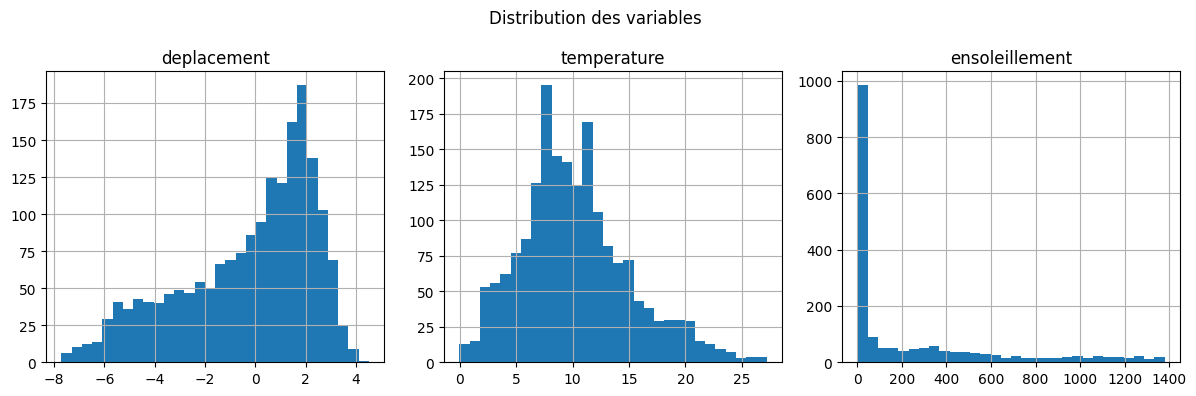

In [49]:
# Distribution 
df[["deplacement", "temperature", "ensoleillement"]].hist(bins=30, figsize=(12, 4), layout=(1, 3))
plt.suptitle("Distribution des variables")
plt.tight_layout()
plt.show()


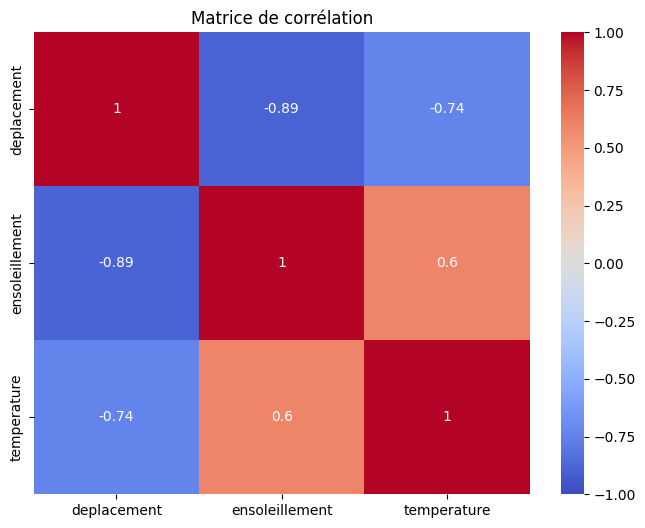

In [50]:
# Corrélation
corr_matrix = df[['deplacement', 'ensoleillement', 'temperature']].corr()

# Affichage avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de corrélation")
plt.show()

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Etudier la multicolinéarité entre les variables: << 5 les variables sont corrélées 
# mais pas au point de supprimer l'un des deux
X = df[['temperature', 'ensoleillement']].assign(const=1)
vif = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns,
    name='VIF'
)
print(vif)

temperature       1.549963
ensoleillement    1.549963
const             5.946708
Name: VIF, dtype: float64


# Modélisation

## Régression linéaire

In [52]:
# Tendance
df["days_since_start"] = (df["ts"] - df["ts"].min()).dt.total_seconds() / 86400

# Saisonnalité (heure)
df["hour"] = df["ts"].dt.hour + df["ts"].dt.minute / 60
df["sin_hour"] = np.sin(2 * np.pi * df["hour"] / 24)
df["cos_hour"] = np.cos(2 * np.pi * df["hour"] / 24)

# Définition des variables explicatives
X = df[['temperature', 'ensoleillement',
        'sin_hour',
        "cos_hour",
        'days_since_start'
        ]]
X = sm.add_constant(X)  # ajoute une constante (intercept)

# Variable cible
y = df['deplacement']

# Régression linéaire
model = sm.OLS(y, X).fit()

# Résumé des résultats statistiques
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            deplacement   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     3669.
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        12:25:34   Log-Likelihood:                -2201.8
No. Observations:                1848   AIC:                             4416.
Df Residuals:                    1842   BIC:                             4449.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.4728      0.066  

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Colinéarité
X = df[['temperature', 'ensoleillement','sin_hour','cos_hour','days_since_start']].assign(const=1)
vif = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns,
    name='VIF'
)
print(vif)

temperature          2.054919
ensoleillement       2.832667
sin_hour             2.754548
cos_hour             1.199812
days_since_start     1.064157
const               12.681753
Name: VIF, dtype: float64


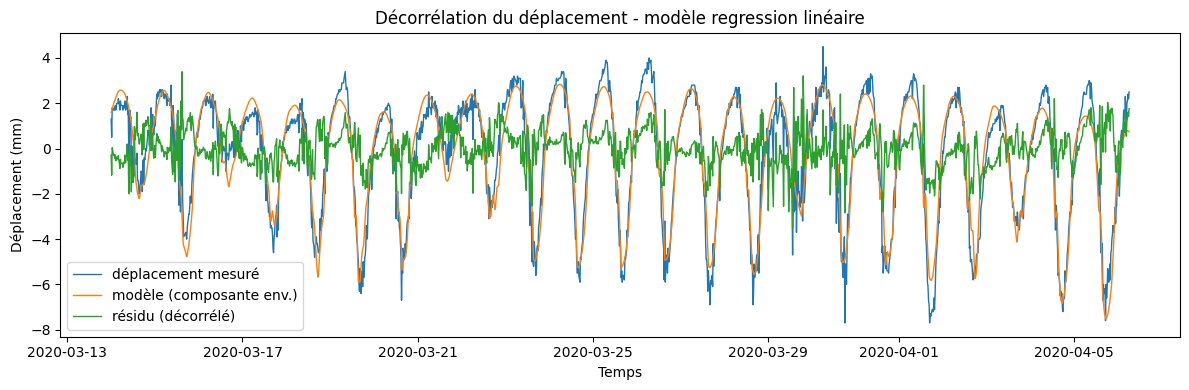

In [54]:
# Plot
X_plot = df[['days_since_start', "temperature", "ensoleillement", "sin_hour", "cos_hour"]]
y_plot = df["deplacement"]

model = LinearRegression()
model.fit(X_plot, y_plot)
y_pred = model.predict(X_plot)
resid = y_plot - y_pred

plt.figure(figsize=(12, 4))
plt.plot(df["ts"], y_plot, label="déplacement mesuré", linewidth=1)
plt.plot(df["ts"], y_pred, label="modèle (composante env.)", linewidth=1)
plt.plot(df["ts"], resid, label="résidu (décorrélé)", linewidth=1)
plt.xlabel("Temps")
plt.ylabel("Déplacement (mm)")
plt.title("Décorrélation du déplacement - modèle regression linéaire")
plt.legend()
plt.tight_layout()
plt.show()


In [55]:
### Prédiction et Evaluation

# Sélection des features
features = ["temperature", "ensoleillement", "sin_hour", "cos_hour", "days_since_start"]
X = df[features].values
y = df["deplacement"].values

# Split train / test (pas de shuffle pour garder l’ordre temporel)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Prédiction
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Évaluation
print("R² train :", r2_score(y_train, y_pred_train))
print("R² test  :", r2_score(y_test, y_pred_test))
print("RMSE train :", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("RMSE test :", np.sqrt(mean_squared_error(y_test, y_pred_test)))


R² train : 0.9072847772365269
R² test  : 0.8770363159042677
RMSE train : 0.7565417907207399
RMSE test : 1.0474078628109698


## Régression quadratique (HST)

Le modèle HST estime le déplacement comme une combinaison des effets environnementaux, saisonniers et temporels :

$$
\text{déplacement}(t) = 
\underbrace{a_0 + a_1 T + a_2 T^2}_{\text{effet thermique}} + 
\underbrace{b_1 E + b_2 E^2}_{\text{effet ensoleillement}} + 
\underbrace{c_1 \sin\left(\frac{2\pi h}{24}\right) + c_2 \cos\left(\frac{2\pi h}{24}\right)}_{\text{saisonnalité horaire}} + 
\underbrace{d_1 t + d_2 t^2}_{\text{tendance lente}}
$$

où :
- $T$ : température  
- $E$ : ensoleillement  
- $h$ : heure (en format décimal, ex : 14h30 = 14.5)  
- $t$ : temps écoulé en jours depuis le début de la série

In [56]:
df["t"] = (df["ts"] - df["ts"].min()).dt.total_seconds() / 86400
df["hour"] = df["ts"].dt.hour + df["ts"].dt.minute / 60
df["sin_hour"] = np.sin(2 * np.pi * df["hour"] / 24)
df["cos_hour"] = np.cos(2 * np.pi * df["hour"] / 24)

# 2. termes polynomiaux
df["temp2"] = df["temperature"]**2
df["ens2"]  = df["ensoleillement"]**2
df["t2"]    = df["t"]**2       # tendance quadratique

# 3. jeu final
X = df[["temperature","temp2",
        "ensoleillement",
        "ens2",
        "sin_hour","cos_hour",
        "t","t2"]]
X = sm.add_constant(X)
y = df["deplacement"]

# 4. régression HST
hst = sm.OLS(y, X).fit()
print(hst.summary())


                            OLS Regression Results                            
Dep. Variable:            deplacement   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     2389.
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        12:25:34   Log-Likelihood:                -2166.0
No. Observations:                1848   AIC:                             4350.
Df Residuals:                    1839   BIC:                             4400.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.3876      0.133     25.

In [57]:
from statsmodels.tsa.ar_model import AutoReg

# Résidu
df["resid"] = df["deplacement"] - hst.predict(X)

# Autorégression sur les résidus: 2 termes
ar_model = AutoReg(df["resid"], lags=2).fit()
print(ar_model.summary())

resid_final = df["resid"][2:] - ar_model.fittedvalues

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                 1848
Model:                     AutoReg(2)   Log Likelihood               -1574.163
Method:               Conditional MLE   S.D. of innovations              0.568
Date:                Mon, 23 Jun 2025   AIC                           3156.326
Time:                        12:25:34   BIC                           3178.409
Sample:                             2   HQIC                          3164.468
                                 1848                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.013      0.145      0.885      -0.024       0.028
resid.L1       0.4945      0.023     21.962      0.000       0.450       0.539
resid.L2       0.2519      0.023     11.178      0.0

Durbin-Watson du résidu final : 2.06


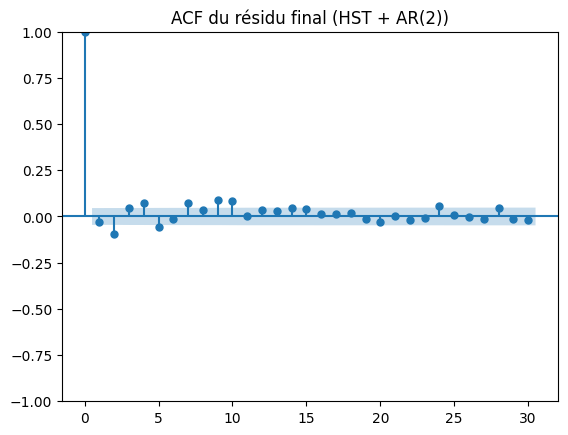

In [58]:
# Test autorégression sur le résidu: Bruit blanc à peu près = 2
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf

dw = durbin_watson(resid_final)
print("Durbin-Watson du résidu final :", round(dw, 3))

plot_acf(resid_final, lags=30)
plt.title("ACF du résidu final (HST + AR(2))")
plt.show()


In [62]:
### Prédiction et Evaluation

# Sélection des features
features = ["temperature","temp2",
        "ensoleillement",
        "ens2",
        "sin_hour","cos_hour",
        "t","t2"]
X = df[features].values
y = df["deplacement"].values

# Split train / test (pas de shuffle pour garder l’ordre temporel)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Prédiction
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Évaluation
print("R² train HST :", r2_score(y_train, y_pred_train))
print("R² test HST :", r2_score(y_test, y_pred_test))
print("RMSE train HST :", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("RMSE test HST :", np.sqrt(mean_squared_error(y_test, y_pred_test)))


R² train HST : 0.910780055985239
R² test HST : 0.8434173734353204
RMSE train HST : 0.7421443290353397
RMSE test HST : 1.1819502134737754


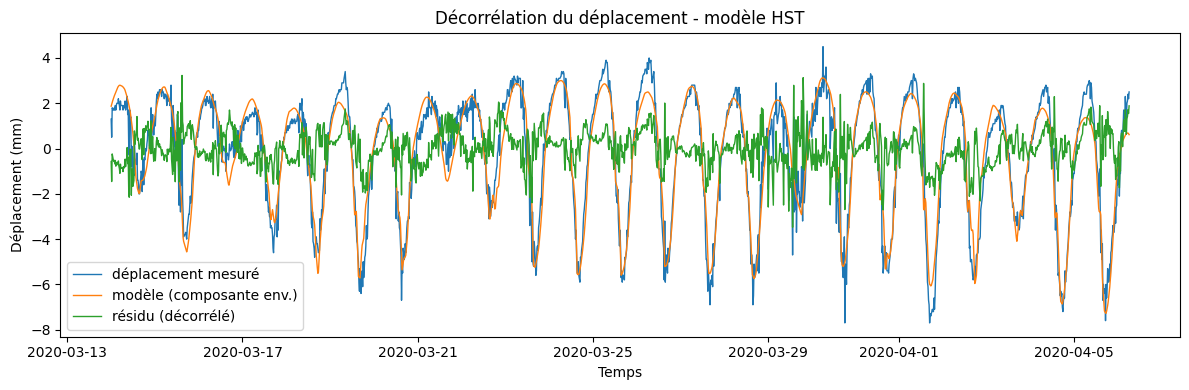

In [61]:
# Plot
X_plot = df[["temperature","temp2",
        "ensoleillement",
        "ens2",
        "sin_hour","cos_hour",
        "t","t2"]]
y_plot = df["deplacement"]

model = LinearRegression()
model.fit(X_plot, y_plot)
y_pred = model.predict(X_plot)
resid = y_plot - y_pred

plt.figure(figsize=(12, 4))
plt.plot(df["ts"], y_plot, label="déplacement mesuré", linewidth=1)
plt.plot(df["ts"], y_pred, label="modèle (composante env.)", linewidth=1)
plt.plot(df["ts"], resid, label="résidu (décorrélé)", linewidth=1)
plt.xlabel("Temps")
plt.ylabel("Déplacement (mm)")
plt.title("Décorrélation du déplacement - modèle HST")
plt.legend()
plt.tight_layout()
plt.show()

## Modèle non linéaire: xgboost

In [63]:
features = ["temperature", "ensoleillement", "sin_hour", "cos_hour", "days_since_start"]
X = df[features].values
y = df["deplacement"].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    # max_depth=5,
    # learning_rate=0.05,
    # subsample=0.8,
    # colsample_bytree=0.8,
)
xgb_model.fit(X_train, y_train)

# Prédiction
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Évaluation
print("XGBoost R² train :", r2_score(y_train, y_pred_train))
print("XGBoost R² test  :", r2_score(y_test, y_pred_test))
print("XGBoost RMSE train:", mean_squared_error(y_train, y_pred_train))
print("XGBoost RMSE test:", mean_squared_error(y_test, y_pred_test))


XGBoost R² train : 0.9983322742812357
XGBoost R² test  : 0.9092446096272043
XGBoost RMSE train: 0.010295309957382955
XGBoost RMSE test: 0.809705747939624


C:\Users\omabe\AppData\Local\Temp\ipykernel_20424\1774200171.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


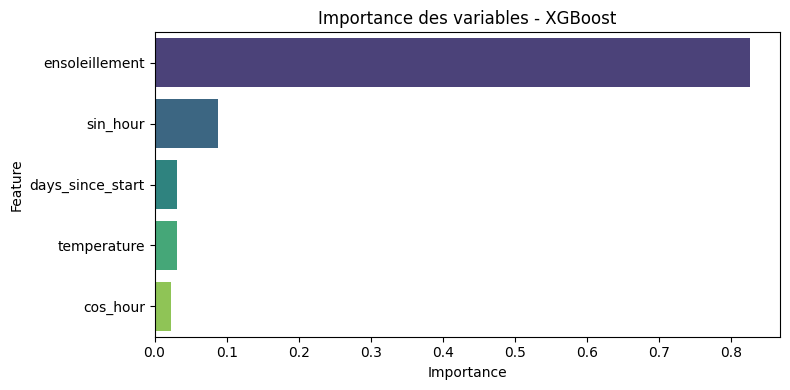

In [64]:
# Récupérer l'importance des features
importances = xgb_model.feature_importances_
feature_names = features

# Créer un DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# Affichage
plt.figure(figsize=(8, 4))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Importance des variables - XGBoost")
plt.tight_layout()
plt.show()


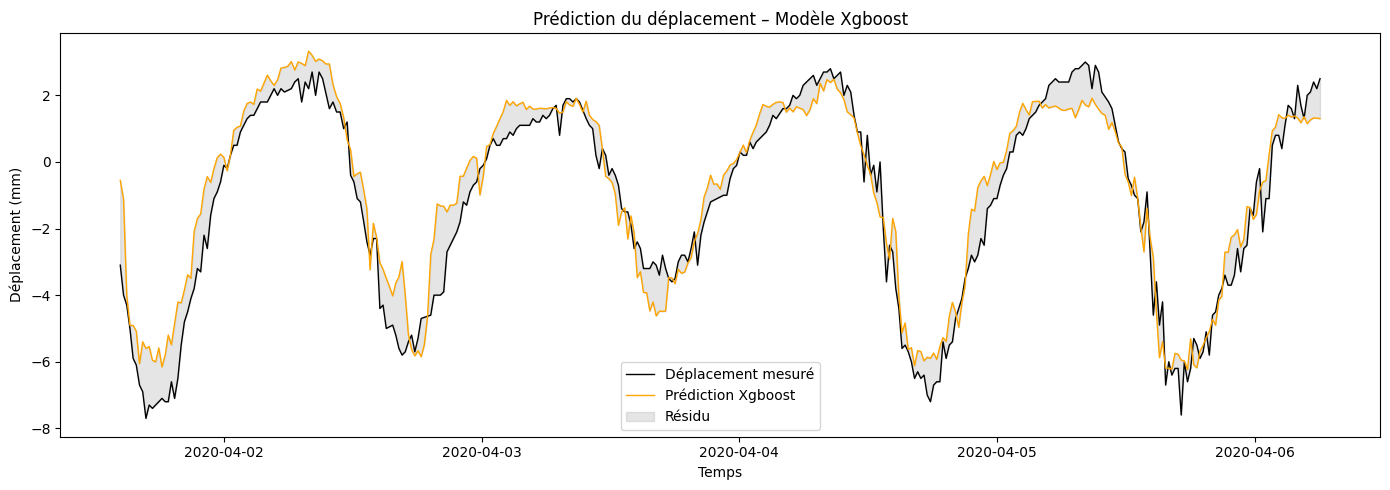

In [38]:
# Affichage résultats sur le jeu de test
ts_train = df["ts"].iloc[:len(y_train)]
ts_test  = df["ts"].iloc[len(y_train):]

# Plots
plt.figure(figsize=(14, 5))

# Partie test uniquement (plus utile pour évaluer la qualité prédictive)
plt.plot(ts_test, y_test, label="Déplacement mesuré", color="black", linewidth=1)
plt.plot(ts_test, y_pred_test, label="Prédiction Xgboost", color="orange", linewidth=1)
plt.fill_between(ts_test, y_test, y_pred_test, color="gray", alpha=0.2, label="Résidu")

plt.xlabel("Temps")
plt.ylabel("Déplacement (mm)")
plt.title("Prédiction du déplacement – Modèle Xgboost")
plt.legend()
plt.tight_layout()
plt.show()

## Réseau de neuronnes 

In [39]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

features = ["temperature", "ensoleillement", "sin_hour", "cos_hour", "days_since_start"]
X = df[features].values
y = df["deplacement"].values

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Modèle MLP
mlp = MLPRegressor(hidden_layer_sizes=(8, 4), activation='relu', solver='adam', 
                   max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Prédiction
y_pred_train = mlp.predict(X_train)
y_pred_test = mlp.predict(X_test)

# Évaluation
print("R² train :", r2_score(y_train, y_pred_train))
print("R² test  :", r2_score(y_test, y_pred_test))
print("RMSE train :", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("RMSE test :", np.sqrt(mean_squared_error(y_test, y_pred_test)))

R² train : 0.9301370152952979
R² test  : 0.914342912332435
RMSE train : 0.6567210966651867
RMSE test : 0.8741964704588133


Using 1478 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/370 [00:00<?, ?it/s]

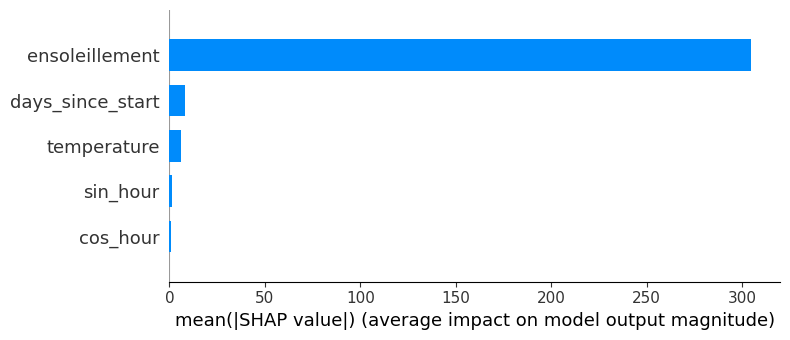

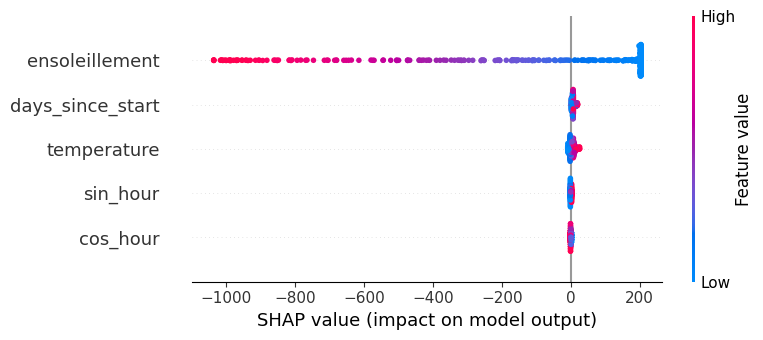

In [67]:
import shap

# Subset (pour que SHAP soit rapide)
X_sample = X_test  # ou moins si nécessaire
X_train_sample = X_train

# Création d’un explainer Kernel (modèle boîte noire)
explainer = shap.KernelExplainer(mlp.predict, X_train_sample)

# Calcul des valeurs SHAP (peut prendre du temps)
shap_values = explainer.shap_values(X_sample, nsamples=100)

# Convertir en DataFrame pour les noms
X_sample_df = pd.DataFrame(X_sample, columns=features)

# Résumé global
shap.summary_plot(shap_values, X_sample_df, plot_type="bar")

# Résumé détaillé (beeswarm)
shap.summary_plot(shap_values, X_sample_df)

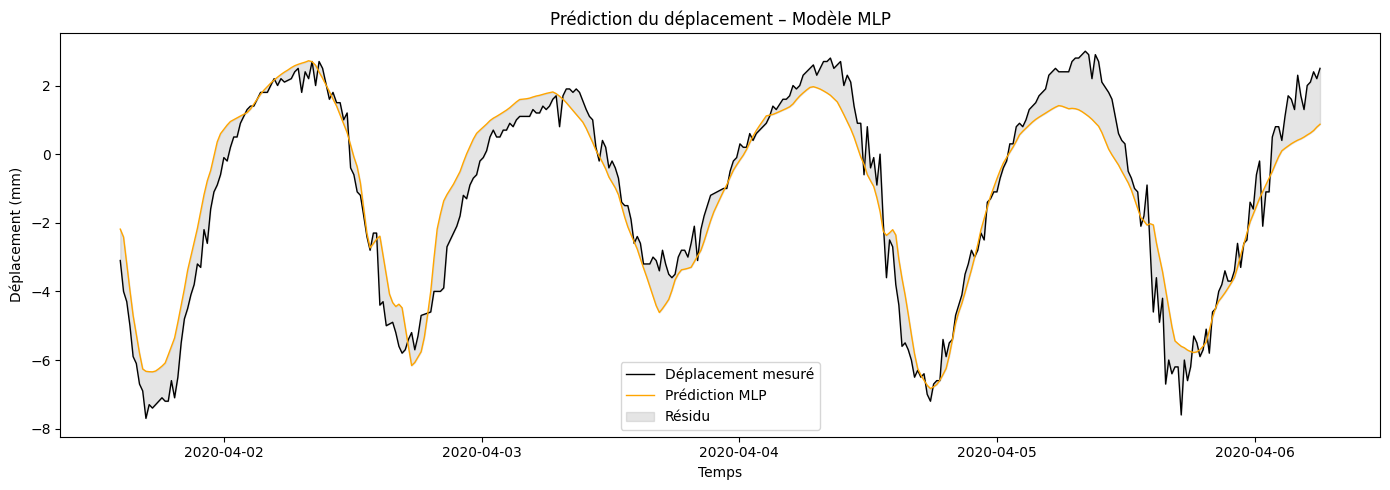

In [40]:
# Affichage résultats sur le jeu de test
ts_train = df["ts"].iloc[:len(y_train)]
ts_test  = df["ts"].iloc[len(y_train):]

# Plots
plt.figure(figsize=(14, 5))

# Partie test uniquement (plus utile pour évaluer la qualité prédictive)
plt.plot(ts_test, y_test, label="Déplacement mesuré", color="black", linewidth=1)
plt.plot(ts_test, y_pred_test, label="Prédiction MLP", color="orange", linewidth=1)
plt.fill_between(ts_test, y_test, y_pred_test, color="gray", alpha=0.2, label="Résidu")

plt.xlabel("Temps")
plt.ylabel("Déplacement (mm)")
plt.title("Prédiction du déplacement – Modèle MLP")
plt.legend()
plt.tight_layout()
plt.show()


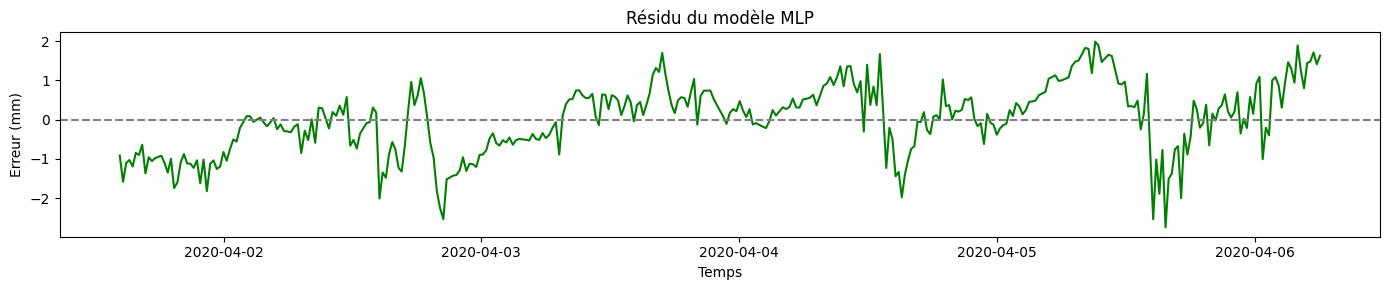

In [41]:
# Résidu
plt.figure(figsize=(14, 3))
plt.plot(ts_test, y_test - y_pred_test, label="Résidu", color="green")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Temps")
plt.ylabel("Erreur (mm)")
plt.title("Résidu du modèle MLP")
plt.tight_layout()
plt.show()

# Enregistrement des résultats

In [21]:
df_test = pd.DataFrame({
    "timestamp": ts_test.values,
    "y_true": y_test,
    "y_pred": y_pred_test,
    "residu": y_test - y_pred_test
})

df_train = pd.DataFrame({
    "timestamp": ts_train.values,
    "y_true": y_train,
    "y_pred": y_pred_train,
    "residu": y_train - y_pred_train
})
df_train.to_csv("resultats_train.csv", index=False)
df_test.to_csv("resultats_test.csv", index=False)